In [1]:
import tensorflow as tf
import numpy as np
from tf_powersfa import *
from tensorflow.keras.layers import *
from tensorflow.nn import *

In [2]:
n_out = 2

In [3]:
batch_size = 1000
N = 1000

encoding_x = tf.placeholder("float", [N,2])
with tf.name_scope("encoder"):
    dense0 = tf.keras.layers.Dense(2)(encoding_x)
encoder_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder')

dense = alt_power_whitening(dense0, 2, 50)[0]


In [4]:
n_hidden = 20

x, y = tf.split(dense, 2, axis=1)
range_bs = list(range(N))
permuted_bs = list(np.random.permutation(range_bs))
sd_indices =  tf.constant([permuted_bs])
sd_indices   = tf.transpose(sd_indices)
shape        = tf.constant([batch_size,1])
y_    = tf.scatter_nd(sd_indices, y, tf.shape(y))

h_join = tf.concat([y, x], axis=1)
h_marg = tf.concat([y_, x], axis=1)

with tf.name_scope("estimator"):
    estimator1 = Dense(n_hidden)
    estimator2 = Dense(n_hidden)
    estimator3 = Dense(n_hidden)
    estimator4 = Dense(n_hidden)
    estimator5 = Dense(n_hidden)
    
    dense1_joint = leaky_relu(estimator1(h_join))
    dense2_joint = leaky_relu(estimator2(dense1_joint))
    dense3_joint = leaky_relu(estimator3(dense2_joint))
    dense4_joint = leaky_relu(estimator4(dense3_joint))
    dense5_joint = estimator5(dense4_joint)

    dense1_marg = leaky_relu(estimator1(h_marg))
    dense2_marg = leaky_relu(estimator2(dense1_marg))
    dense3_marg = leaky_relu(estimator3(dense2_marg))
    dense4_marg = leaky_relu(estimator4(dense3_marg))
    dense5_marg = estimator5(dense4_marg)

estimator_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='estimator')

loss = tf.reduce_mean(dense5_joint)-tf.log(tf.reduce_mean(tf.exp(dense5_marg)))
train_encoder     = tf.train.AdamOptimizer(0.005).minimize(loss, var_list=encoder_var_list)
train_step = tf.contrib.opt.NadamOptimizer(0.002).minimize(-loss, var_list=estimator_var_list)


/home/hlynur/.local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 2
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


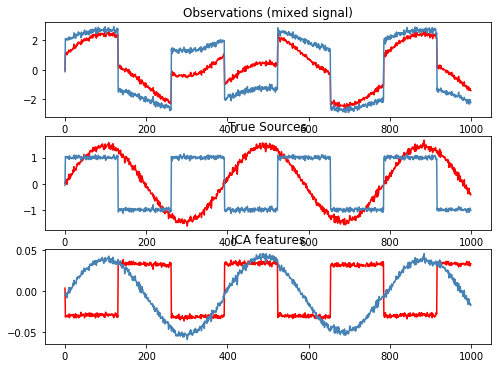

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

time = np.linspace(0, 8, batch_size)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
S = np.c_[s1, s2]
S += 0.05 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1], [0.5, 2]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Solve the task with FastICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals


models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue']
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

step: 0, loss: -0.001953267492353916


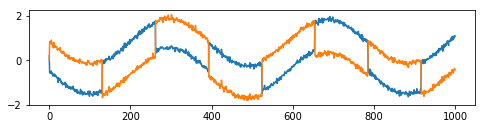

step: 100, loss: 1.3983328342437744
step: 200, loss: 1.9960780143737793
step: 300, loss: 1.1530094146728516
step: 400, loss: 1.1368141174316406


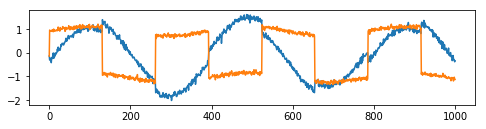

step: 500, loss: 0.9841361045837402
step: 600, loss: 0.6130414009094238
step: 700, loss: 0.004491090774536133
step: 800, loss: 0.058680057525634766


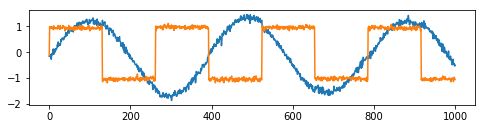

step: 900, loss: 0.041075825691223145
step: 1000, loss: 0.04190543293952942
step: 1100, loss: 0.04469601437449455
step: 1200, loss: 0.053121812641620636


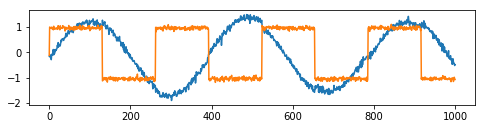

step: 1300, loss: 0.05415046215057373
step: 1400, loss: 0.05720019340515137
step: 1500, loss: 0.061237335205078125
step: 1600, loss: 0.05753013491630554


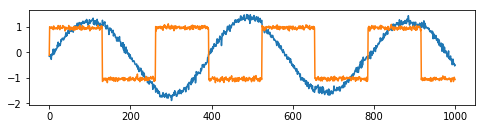

step: 1700, loss: 0.06024104356765747
step: 1800, loss: 0.06680917739868164
step: 1900, loss: 0.06736141443252563
step: 2000, loss: 0.06371420621871948


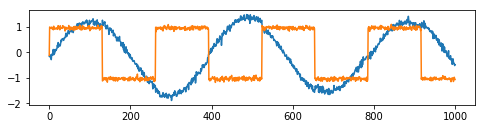

In [6]:
shuffled_x = np.array(X)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(2001):
        current_loss, _ = sess.run([loss, train_step], feed_dict={encoding_x:X})
        if i % 2 is 0: 
            current_loss, _ = sess.run([loss, train_encoder], feed_dict={encoding_x:X})
            np.random.shuffle(shuffled_x)
        if i % 100 is 0: print("step: {}, loss: {}".format(i, current_loss))         
        if i % 400 is 0:
            #v = sess.run(Wx)
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            plt.plot(encoding)
            plt.show()